<a href="https://colab.research.google.com/github/hartwj/Lending_Club/blob/master/Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Lending Club Assignment

This assignment was completed for my machine learning in Python class at the University of Pennsylvania. We were instructed to develop and train a model that could predict whether a borrower would be accepeted or denied a loan, using data from lending club. 

Each row of the file represents a single user
account on **LendingClub.com**. The site consists of two types of users, **borrowers** who are applying for a new loan, and **investors** who lend money for fixed periods of time. Each row in our dataset represents a single borrower at the time they apply for their first peer-to-peer loan, and each row contains nine columns:

- Amount requested for their first loan
- Year the loan was requested (this dataset covers only a five-year period, 2008-2012)
- Title of the loan application (written by the borrower)
- FICO score (credit rating) of the borrower
- “Debt-to-Income”: A ratio of the borrower’s total monthly debt payments, excluding home
mortgage and the requested loan, to the borrower’s self-reported monthly income.
- ZIP code of the borrower (the last two digits of each ZIP are masked for anonymity)
- U.S. state that the borrower resides in.
- Length of time that the borrower has been employed at their current job, from 0 to 10+ years.
- A binary outcome variable for whether the user’s loan application was accepted by investors.


In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import calendar
import itertools
from scipy import stats
from matplotlib import dates
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Download the Data 
Keep this if you are working in Google Colab. Delete this if you are working on your own computer and have the data downloaded already. 

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3' -O lendingclub.csv

--2020-07-29 01:34:22--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.138, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iege4cjorsep91j9gn36aqn11vsu55e8/1595986425000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download [following]
--2020-07-29 01:34:23--  https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iege4cjorsep91j9gn36aqn11vsu55e8/1595986425000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download
Resolving doc-10-5c-docs.googleusercontent.com (doc-10-5c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to do

# Training a Decision Tree Classifier: 

The task is predicting the outcome of each applicant's proposal. Labels are binary - approved or rejected. There are several possible features - ranging from loan amount to fico score to employment history. The first step is building a decision tree to evaluate which features matter for our prediction

In [ ]:
lendingclub = pd.read_csv("lendingclub.csv")
lendingclub.head()

,amount,date,title,fico,dti,zip,state,emp_length,policy_code,year,outcome
0,2500.0,Dec-2011,bike,740.0,1.00,309xx,GA,< 1 year,1.0,2011,accept
1,12000.0,Dec-2011,Consolidation,675.0,10.78,913xx,CA,10+ years,1.0,2011,accept
2,21000.0,Dec-2011,Debt Cleanup,705.0,13.22,335xx,FL,10+ years,1.0,2011,accept
3,31825.0,Dec-2011,Debt Consolidation Loan,760.0,14.03,080xx,NJ,5 years,1.0,2011,accept
4,12000.0,Dec-2011,Debt Consolidation,725.0,16.70,088xx,NJ,10+ years,1.0,2011,accept


In [ ]:
#We need outcome to be binary - True/False
#This step recodes Accept as True and Reject as False
lendingclub["Accept"] = lendingclub["outcome"] == "accept"
lendingclub.tail()

,amount,date,title,fico,dti,zip,state,emp_length,policy_code,year,outcome,Accept
81098,2000.0,2012-12-31,other,615.0,56.33,365xx,AL,< 1 year,0.0,2012,reject,False
81099,2000.0,2012-12-31,car,572.0,16.90,363xx,AL,< 1 year,0.0,2012,reject,False
81100,35000.0,2012-12-31,debt_consolidation,556.0,21.44,347xx,FL,< 1 year,0.0,2012,reject,False
81101,25000.0,2012-12-31,other,506.0,12.99,404xx,KY,< 1 year,0.0,2012,reject,False
81102,35000.0,2012-12-31,other,597.0,4.13,211xx,MD,< 1 year,0.0,2012,reject,False


In [ ]:
# As a data scientist there are pre-processing decisions that must be made
# Evaluating all possible features, there are certain variables that can be ignored
# Date is irrelevant  - it shouldn't have an impact on whether a loan is accepted or rejected
# Title is messy and qualitative. There's too many possibilites to neatly organize it
# Zip has been de-identified. This removes the possibility of learning precise locational info about the borrower
      #It also hinders our ability to make a recommendation (i.e. identifying rich vs. poor neighborhoods)
# This leaves us with the following features to test: 
# Amount, FICO, DTI, State, and Employment Length

As a data scientist there are pre-processing decisions that must be made. Evaluating all possible features, there are certain variables that can be ignored. 

- Date is irrelevant  - it shouldn't have an impact on whether a loan is accepted or rejected
- Title is messy and qualitative. There's too many possibilites to neatly organize it
- Zip has been de-identified. This removes the possibility of learning precise locational info about the borrower
  - It also hinders our ability to make a recommendation (i.e. identifying rich vs. poor neighborhoods)

This leaves us with the following features to test: 
 - Amount, FICO, DTI, State, and Employment Length

(array([57065.,  5959.,  2135.,   830.,  1627.,  3362.,  2690.,  1243.,
         1054.,  5138.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

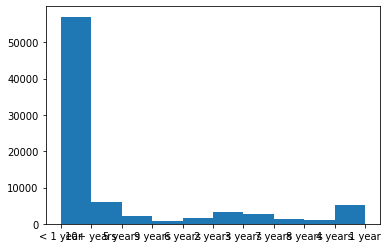

In [ ]:
plt.hist(lendingclub["emp_length"])


In [ ]:
#Now let's normalize employment length
#It's messy and heavy text based
#This new custom function will break it down into 3 categories - short, medium, and long
def employ_norm(x):
    if x == "< 1 year":
        return "short"
    if x == "2 years":
        return "short"
    if x == "3 years":
        return "short"
    if x == "4 years":
        return "medium"
    if x == "5 years":
        return "medium"
    if x == "6 years":
        return "medium"
    if x == "7 years":
        return "long"
    if x == "8 years":
        return "long"
    if x == "9 years":
        return "long"
    if x == "10+ years":
        return "long"
    
lendingclub["employ_norm"] = lendingclub["emp_length"].apply(employ_norm)
lendingclub["employ_norm"].value_counts()

short     63117
long       9086
medium     5937
Name: employ_norm, dtype: int64

In [ ]:
# Now I'm building the decision tree model
# I'll be looking at amount, fico, dti, state, and employment length and building 6 different models (labelled in feature_sets)
# For the first run, these will be evaluated on accuracy and # of leaves
# The hyperparamters will be splitting based on entropy and we will not be adjusting the leaf purity or sample split
loan_features = ["amount"]
credit_features = ["fico", "dti"]
location_features = ["state"]
employment_features = ["employ_norm"]

feature_sets = {
    "loan only": loan_features,
    "credit only": credit_features,
    "loan and credit": loan_features + credit_features,
    "location only": location_features,
    "employment only": employment_features,
    "all features": loan_features + credit_features + location_features + employment_features
}

best = 0
best_name = None

for set_name, feature_set in feature_sets.items():

    X = lendingclub.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = lendingclub["Accept"]

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X, y)
    y_pred = model.predict(X)

    y_matches = (y_pred == y)
    accuracy = 100*accuracy_score(y, y_pred)
    if accuracy >= best:
        best = accuracy
        best_name = set_name
        

    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Feature set: {set_name}")
    print(f"   Accuracy: {accuracy:.1f}%")
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    

print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")    

Feature set: loan only
   Accuracy: 90.4%
   Tree contains 891 leaves
Feature set: credit only
   Accuracy: 99.4%
   Tree contains 5260 leaves
Feature set: loan and credit
   Accuracy: 100.0%
   Tree contains 4748 leaves
Feature set: location only
   Accuracy: 88.6%
   Tree contains 51 leaves
Feature set: employment only
   Accuracy: 88.6%
   Tree contains 4 leaves
Feature set: all features
   Accuracy: 100.0%
   Tree contains 3930 leaves
Best feature set is: all features 
With: 100.0% accuracy.


In [ ]:
#Loan and credit is able to get 100% accuracy on predicting acceptance
#All features also predicts 100% accuracy - but it proves that location and employment are potentially less important
#Now lets evaluate the models based on precision, recall, and kappa

In [ ]:
best = 0
best_name = None

precisions = []
recalls = []
kappas = []
accuracies = []

predictions = {}
actual = None

for set_name, feature_set in feature_sets.items():

    X = lendingclub.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = lendingclub["Accept"]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = 100*accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metric_to_optimize = accuracy
    
    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = set_name
        
    predictions[set_name] = y_pred
    actual = np.array(list(y_test))
    
    # Bookkeeping and printing for the reader (not part of the core loop)
    print(f"Results for {set_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
    precisions.append(precision)
    recalls.append(recall)
    kappas.append(kappa)
    accuracies.append(accuracy)
    print(f"   Tree contains {model.get_n_leaves()} leaves")
    print("------------------------")

   
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.") 

Results for loan only:
[[14178   171]
 [ 1489   383]]
Accuracy: 89.8 Kappa: 0.278 Precision: 0.691 Recall: 0.205
   Tree contains 822 leaves
------------------------
Results for credit only:
[[13838   511]
 [  508  1364]]
Accuracy: 93.7 Kappa: 0.693 Precision: 0.727 Recall: 0.729
   Tree contains 4253 leaves
------------------------
Results for loan and credit:
[[13856   493]
 [  521  1351]]
Accuracy: 93.7 Kappa: 0.692 Precision: 0.733 Recall: 0.722
   Tree contains 3759 leaves
------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for location only:
[[14349     0]
 [ 1872     0]]
Accuracy: 88.5 Kappa: 0.000 Precision: 0.000 Recall: 0.000
   Tree contains 51 leaves
------------------------
Results for employment only:
[[14349     0]
 [ 1872     0]]
Accuracy: 88.5 Kappa: 0.000 Precision: 0.000 Recall: 0.000
   Tree contains 4 leaves
------------------------
Results for all features:
[[13767   582]
 [  518  1354]]
Accuracy: 93.2 Kappa: 0.673 Precision: 0.699 Recall: 0.723
   Tree contains 3397 leaves
------------------------
Best feature set is: loan and credit 
With: 93.7% accuracy.


In [ ]:
#Our best features are loan amount, fico score, and debt-income ratio
#Its results are very similar to credit only, but has less leaves
#While these results are good, the model will need to be further trained to reduce leaves

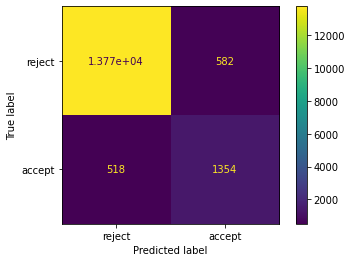

In [ ]:
#I ran a confusion matrix to examine our Y test and Y predict
# The matrix shows the model does a very good job of accurately assigning accepts and rejects
lendingclub["Reject"] = lendingclub["outcome"] == "reject"
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, ["reject", "accept"] ).plot(values_format='.4g')
plt.show()

# Review: 



The credit + loan model is 93% accurate. The precision, which evaluates all of our predicted "accepts" is 0.733. For business idea #1, where Lending Club is adding loans with high-likelihoods of acceptance to their balance sheet, this means that we would invest in some loans that will never be off-loaded to other investors. Not really a big problem, but it's not ideal. Ideally, precision would be 0.9 or greater.

For the second business idea (auto-rejecting certain clients), our recall is 0.722, which is evaluating all of our models' "reject" predictions. Similar to precision, it would be much better in the 0.9+ range. The downside here is that we'll be rejecting some loans automatically that could have found investors later on. So it's more of a failed opportunity for origination and service fees. It's hard to quantify the benefits of business idea #2, but it could attract more borrowers to the platform with promises of automatic responses. 